# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [129]:
import pandas as pd
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectFromModel
from warnings import filterwarnings
filterwarnings('ignore')

In [82]:
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
#считываем данные

In [83]:
labels = labels.applymap(lambda x: 0 if x == -1 else x)
#заменим значение метки -1 на 0

In [71]:
data.dropna(how='all', axis=1, inplace=True)
data.shape
#удалим полностью пустые столбцы

(40000, 212)

In [34]:
data.fillna(0, inplace=True)
#заменим все пустые значения на 0

In [72]:
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
#стандартизуем числовые данные 

In [75]:
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')
#приведем все значения категориальных признаков к одному типу

In [78]:
# для преобразования категориальных фич используем LabelEncoder
for i in range(174, 212):
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])

In [10]:
def learning_curve_plot(data, labels, estimator, train_sizes = np.linspace(0.1, 1.0, 10)):
    """Строит график кривой обучения"""
    plt.figure(figsize=(20, 6))
    plt.title('Learning curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, data, labels, train_sizes=train_sizes,
                                                       groups=labels, scoring='roc_auc', cv=5, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                    alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                    alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='cv score')
    
    plt.legend()
    return plt

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

<module 'matplotlib.pyplot' from '/home/double_dee/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

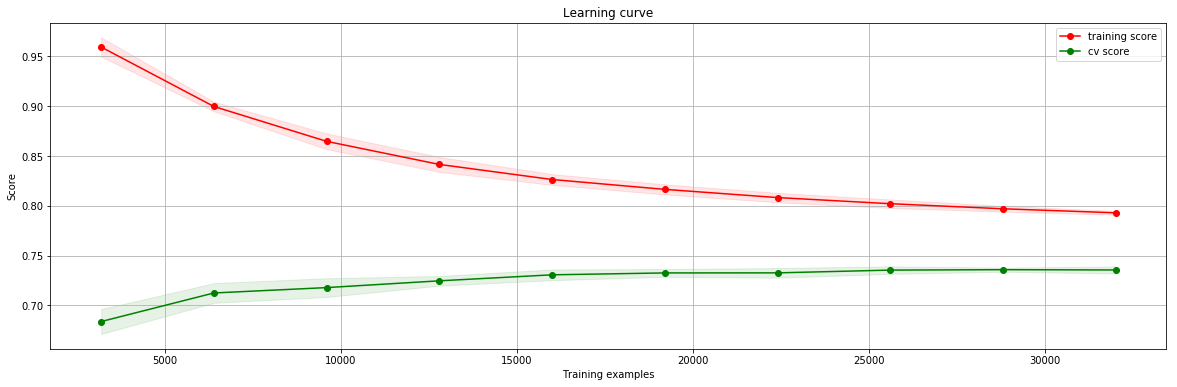

In [11]:
gbc = GradientBoostingClassifier(n_estimators=100, verbose=0, random_state=1)

learning_curve_plot(data, labels, gbc)

Видим, что качество перестает расти примерно с 16-18 тыс. Для подбора параметров модели можно использовать усеченную выборку, а для финального предсказания полную.

## Инструкции

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Я не нашел как задать веса в GradientBoostingClassifier поэтому воспользуюсь XGBClassifier 

In [12]:
from xgboost import XGBClassifier

In [140]:
import xgboost
xgboost.__version__

'0.90'

In [13]:
skf = StratifiedKFold()

In [14]:
labels = labels.labels

In [15]:
class_minus = labels.value_counts()[0] 
class_plus = labels.value_counts()[1] 

weights = [
    class_minus / class_plus ,  # Сбалансированный
    class_minus * 1.2/ class_plus,
    class_minus * 1.7 / class_plus,  # дисбаланс в сторону class_minus
    class_minus / 1.2 / class_plus,
    class_minus / 1.7 / class_plus  # дисбаланс в сторону class_plus
]

for weight in weights:
    xgbc = XGBClassifier(max_depth=5, n_estimators=50, scale_pos_weight=weight)
    print('Значение ROC-AUC на кросс-валидации при соотношении весов {} равно '.format(weight), 
          cross_val_score(xgbc, data, labels, scoring='roc_auc', cv=skf).mean())

Значение ROC-AUC на кросс-валидации при соотношении весов 12.440860215053764 равно  0.7286737973070784
Значение ROC-AUC на кросс-валидации при соотношении весов 14.929032258064515 равно  0.7275050703905718
Значение ROC-AUC на кросс-валидации при соотношении весов 21.149462365591397 равно  0.7226470678299243
Значение ROC-AUC на кросс-валидации при соотношении весов 10.367383512544803 равно  0.7293761970868583
Значение ROC-AUC на кросс-валидации при соотношении весов 7.318153067678685 равно  0.7325805712702177


Лучшее значение показывает наименьшее соотношение классов, т.е. уменьшение веса класса 0.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [16]:
# сoef регулирует количество нулевого класса, 0 < coef < 1
def undersampling(data, labels, coef=1):
    pos_indices = labels[labels > 0.5].index
    neg_indices = labels[labels < 0.5].index
    undersampled_data = data.iloc[pos_indices, :]
    data_to_append = data.iloc[neg_indices, :].sample(frac=coef)
    undersampled_data = pd.concat((undersampled_data, data_to_append), ignore_index=False, axis=0)
    return undersampled_data, labels[undersampled_data.index]

In [17]:
for coef in [0.25, 0.5, 0.75]:
    undersampled_data, undersampled_labels = undersampling(data, labels, coef=coef)
    print('coef = ', coef, 'ROC_AUC: ', cross_val_score(gbc, undersampled_data, undersampled_labels, scoring='roc_auc', cv=5).mean())

coef =  0.25 ROC_AUC:  0.7320180047532499
coef =  0.5 ROC_AUC:  0.7365955429865656
coef =  0.75 ROC_AUC:  0.7369452781029875


Видим, что значения практически одинаковые, следовательно undersampling может помочь в ускорении обучения модели. 
Лучшее качество показало уменьшение отрицательного класса на 25%.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Перед использованием новой стратегии, каждый раз считываем файлы, удаляем пустые столбцы, обрабатываем числовые признаки, затем обрабатываем категориальные фичи, затем считаем средний ROC_AUC через кросс_валидацию

Замена пропусков наиболее часто встречающимся значением в фиче

In [18]:
for i in range(211):
    if data[data.columns[i]].value_counts().index[0] != 0:
        most_freq = data[data.columns[i]].value_counts().index[0]
        data[data.columns[i]].fillna(most_freq, inplace=True)
    else:
        most_freq = data[data.columns[i]].value_counts().index[1]
        data[data.columns[i]].fillna(most_freq, inplace=True)

In [19]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7337004742729722


Замена пропусков в числовых признаках средним значением, а в категориальных признаках наиболее часто встречающимся значением в фиче

In [43]:
for i in range(174):
    mean = np.mean(data[data.columns[i]])
    data[data.columns[i]].fillna(mean, inplace=True)
    
for i in range(174, 211):
    most_freq = data[data.columns[i]].value_counts().index[0]
    data[data.columns[i]].fillna(most_freq, inplace=True)

In [44]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7338083849065749


Замена пропусков в числовых признаках нулями, а в категориальных признаках наиболее часто встречающимся значением в фиче

In [79]:
for i in range(174):
    data[data.columns[i]].fillna(0, inplace=True)
    
for i in range(174, 211):
    most_freq = data[data.columns[i]].value_counts().index[0]
    data[data.columns[i]].fillna(most_freq, inplace=True)

In [80]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7338324442984429


Замена всех пропусков нулями

In [57]:
data.fillna(0, inplace=True)

In [60]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7343075323385787


Лучший результат показала стратегия: замена всех пропусков нулями 

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [81]:
# Объединение значений, чье число меньше n
def unite_less(column, n):
    val = column.value_counts()
    new_val = (val >= n) * range(1, len(val) + 1)
    return column.map(new_val)

Ранее мы использовали label encoding, посмотрим на его качество после объеденения малочисленных значений категориальных фич

In [87]:
#загрузим и предобработаем данные
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
data.dropna(how='all', axis=1, inplace=True)
data.fillna(0, inplace=True)
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')

In [88]:
data.iloc[:, 174:] = data.iloc[:, 174:].apply(lambda x: unite_less(x, 100))
for i in range(174, 212):
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])

In [89]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7369036434965879


Для альтернативы используем, get_dummies из pandas

In [90]:
#загрузим и предобработаем данные
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
data.dropna(how='all', axis=1, inplace=True)
data.fillna(0, inplace=True)
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')

In [91]:
data.iloc[:, 174:] = data.iloc[:, 174:].apply(lambda x: unite_less(x, 100))
cat_columns = data.iloc[:, 174:].columns
data = pd.get_dummies(data, drop_first=True, columns=cat_columns)

In [92]:
print(cross_val_score(gbc, data, labels, scoring='roc_auc', cv=skf).mean())

0.7384859407001215


Видим незначительное улучшение для get_dummies, но по скольку расчет занимает значительно больше времени и на выходе мы имеем сильно разреженный датафрейм, для финального предсказания будем использовать label encoding

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [93]:
from sklearn.linear_model import Lasso

Построим отбор на основе l1 регуляризации.

In [94]:
#загрузим и предобработаем данные
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
data.dropna(how='all', axis=1, inplace=True)
data.fillna(0, inplace=True)
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')
data.iloc[:, 174:] = data.iloc[:, 174:].apply(lambda x: unite_less(x, 100))
for i in range(174, 212):
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])

In [95]:
lasso = Lasso(alpha=0.01)
lasso.fit(data, labels)
model = SelectFromModel(lasso, prefit=True)
selected_data = model.transform(data)
selected_data.shape

(40000, 12)

видим, что L1-регуляризатор занулил большинство признаков, проверим качество модели.

In [96]:
print(cross_val_score(gbc, selected_data, labels, scoring='roc_auc', cv=skf).mean())

0.713984370312006


Используем метод feature_importance для отбора фичей.

In [97]:
#загрузим и предобработаем данные
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
data.dropna(how='all', axis=1, inplace=True)
data.fillna(0, inplace=True)
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')
data.iloc[:, 174:] = data.iloc[:, 174:].apply(lambda x: unite_less(x, 100))
for i in range(174, 212):
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])

In [98]:
gbc.fit(data, labels)
cols_selected = data.columns[gbc.feature_importances_ > 0.0005]
selected_data = data[cols_selected]
selected_data.shape

(40000, 82)

In [99]:
print(cross_val_score(gbc, selected_data, labels, scoring='roc_auc', cv=skf).mean())

0.7367803373952403


Отбор признаков не улучшил качество модели, но увеличил скорость обучения

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [100]:
est = GradientBoostingClassifier()

params = {'max_depth': [3, 4, 5, 6],
         'n_estimators': [50, 60, 70, 90, 100],
         'learning_rate': [0.05, 0.1]}
grid = GridSearchCV(est, param_grid=params, scoring='roc_auc', cv=skf, n_jobs=-1)
grid.fit(selected_data, labels)
print(grid.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [101]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=4, verbose=0, learning_rate=0.05, random_state=1)
print(cross_val_score(gbc, selected_data, labels, scoring='roc_auc', cv=skf).mean())

0.7383065097325261


Подбор параметров, почти не изменил качество, что логично - подобранные параметры близки к нашим дефолтным.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [103]:
gbc.fit(selected_data, labels)
# Топ-20 признаков
feature_importance = sorted(list(zip(selected_data.columns, gbc.feature_importances_)), 
                            key=lambda x: x[1], reverse=True)[:20]
feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance']) 

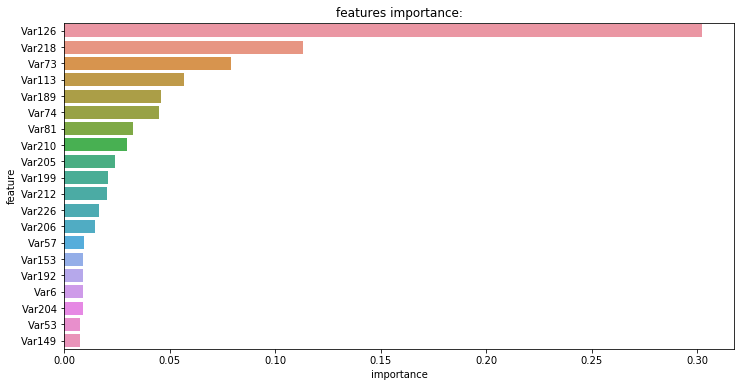

In [118]:
plt.figure(figsize=(12, 6));
sns.barplot(x='importance', y='feature', data=feature_importance);
plt.title('features importance:');

наибольший вклад в модель внес признак 'Var126', так же видим, что почти половина в топ 20 это категориальные признаки.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли между этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [120]:
gbc.fit(selected_data.iloc[:, :-1], labels)
not_important_features = sorted(list(zip(selected_data.iloc[:, :-1].columns, 
                                         gbc.feature_importances_)), key=lambda x: x[1], reverse=False)[:10]
not_important_features = [i[0] for i in not_important_features[:10]]

In [121]:
selected_data['labels'] = labels

In [122]:
selected_data_churn = selected_data[selected_data['labels'] == 1]
selected_data_not_churn = selected_data[selected_data['labels'] == 0]

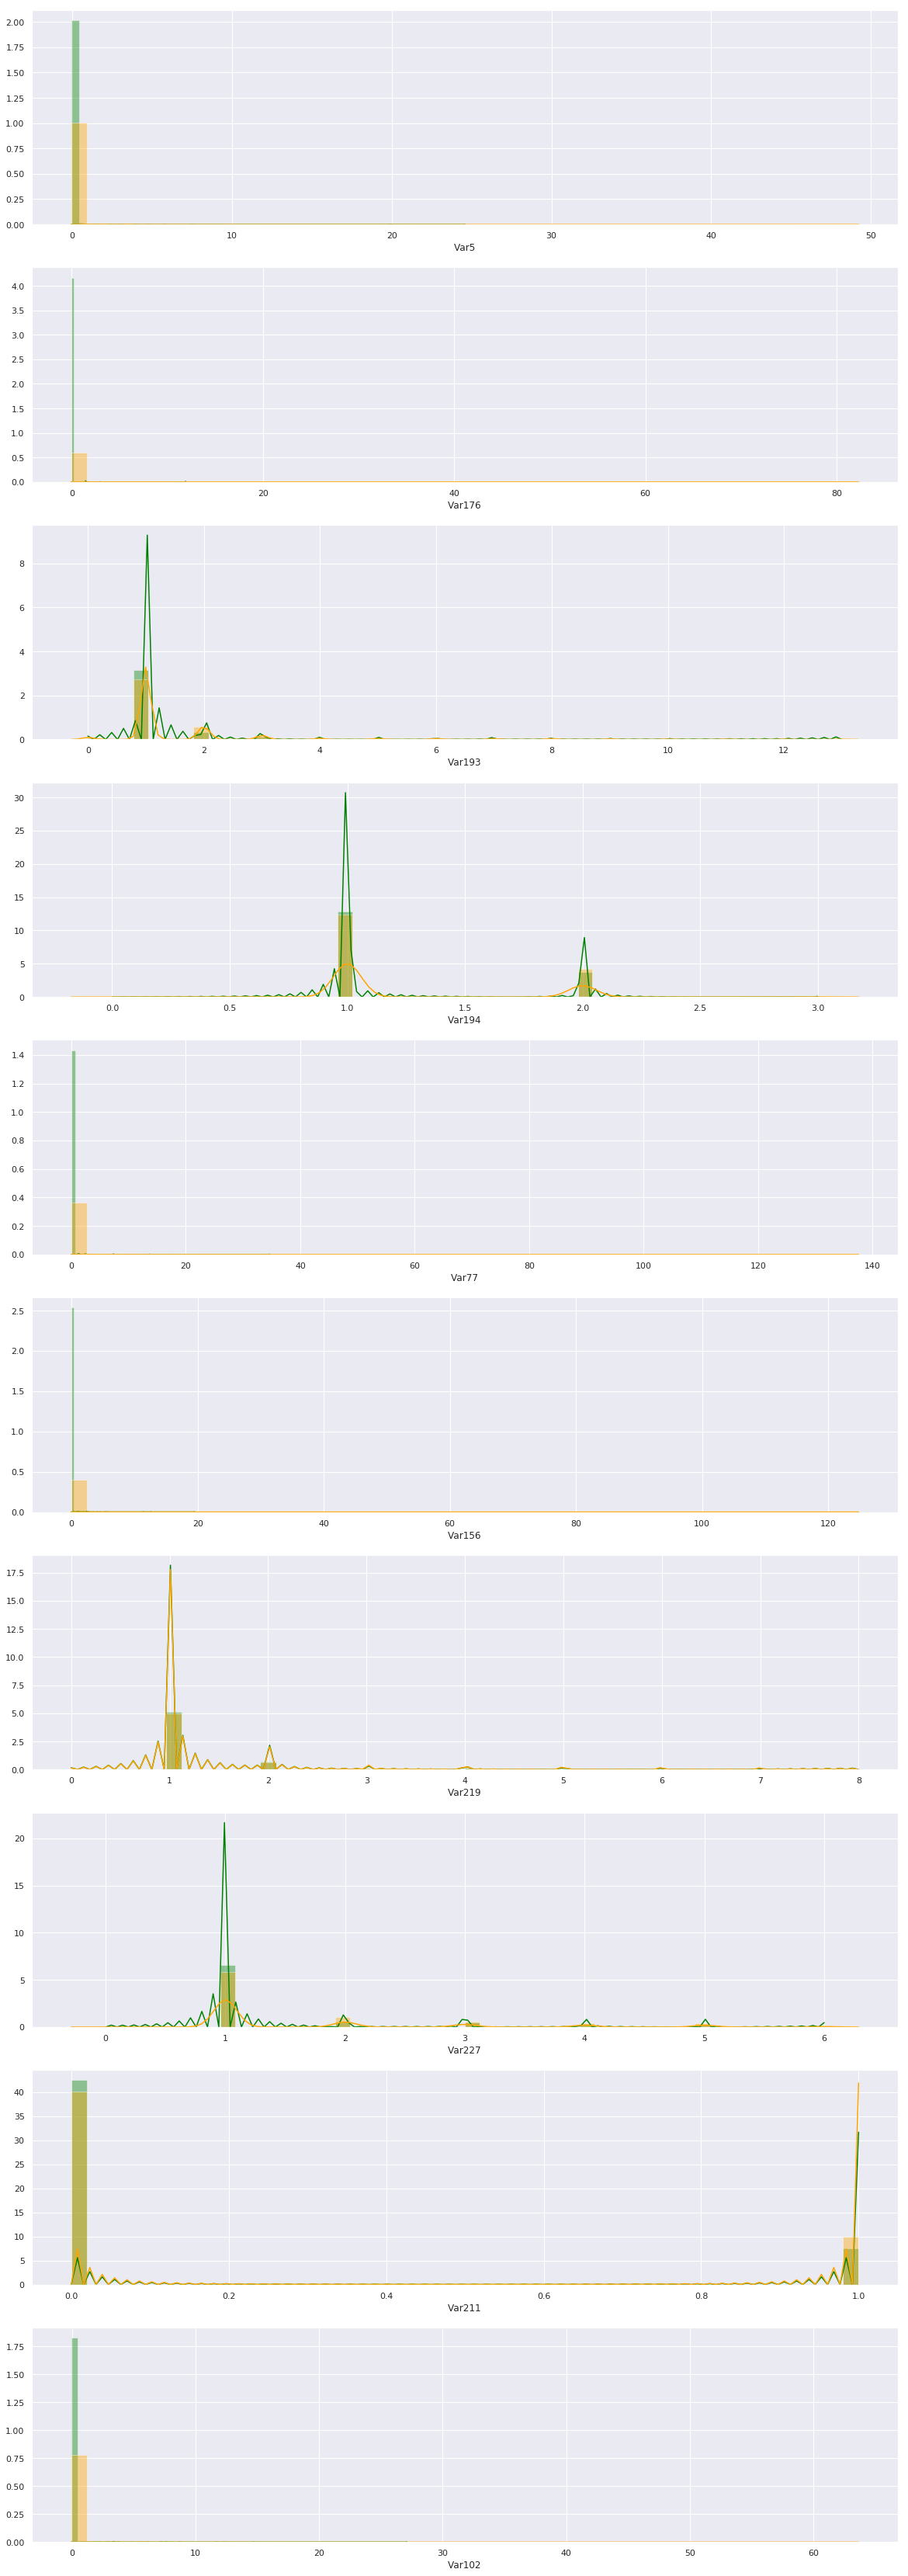

In [124]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs,  not_important_features):
    sns.distplot(selected_data_churn[column], ax = ax, color = "green", label = str(column)+" label = 1")
    sns.distplot(selected_data_not_churn[column], ax = ax, color = "orange", label = str(column)+" label = 0")

Худшие из отобранных признаков имеют выбросы. Скорее всего это и послужило одной из причин достижения большой ошибки на этих признаках.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Для построения моделя я выбрал GradientBoostingClassifier. Подбором были выбраны следущие параметры: learning_rate = 0.05, max_depth = 4, n_estimators = 100.

Обработка данных: Удалили полностью пустые столбцы. Пустые значения признаков заменили на 0. Числовые признаки были стандартизованы. При обработке категориальных признаков объеденяли категории  если их меньше 100, далее использовали LabelEncoding. Далее произвели отбор фич с помощью метода feature_importance.

In [125]:
gbc = GradientBoostingClassifier(n_estimators=100, verbose=0, learning_rate=0.05, random_state=1)

In [127]:
#загрузим и предобработаем данные
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header=None, names = ['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
data.dropna(how='all', axis=1, inplace=True)
data.fillna(0, inplace=True)
data.iloc[:, :174] = StandardScaler().fit_transform(data.iloc[:, :174])
data.iloc[:, 174:] = data.iloc[:, 174:].astype('str')
data.iloc[:, 174:] = data.iloc[:, 174:].apply(lambda x: unite_less(x, 100))

for i in range(174, 212):
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])

    

In [128]:
gbc.fit(data, labels)
cols_selected = data.columns[gbc.feature_importances_ > 0.0005]
selected_data = data[cols_selected]

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Думаю если поработать с выбросами, модель можно еще улучшить.